# Embed complaints 

In [65]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
import json


In [66]:
# get the API key from the json file
with open('openai_key.json') as f:
    data = json.load(f)
    api_key = data['OPENAI_API_KEY']
    openai.api_key = api_key

In [72]:
# load the complaints from csv friendly format into a dataframe
complaints = pd.read_csv('banking_service_varied_comments.csv')
# loop over complaints and get the embeddings
embeddings = []
for complaint in complaints['Complaint']:
    model="text-embedding-ada-002"
    vec = openai.Embedding.create(input = [complaint], model=model)['data'][0]['embedding']
    embeddings.append(vec)
# add the embeddings to the dataframe
complaints['embeddings'] = embeddings
complaints.head()
# save the dataframe to csv for later use
complaints.to_csv('banking_service_comments_Embed.csv')


<class 'numpy.ndarray'>


In [92]:
# Read complaints in and map the categories to numbers in Area
complaints = pd.read_csv('banking_service_comments_Embed.csv')
categories = complaints['Category'].unique()    
category_map = {}
for i in range(len(categories)):
    category_map[categories[i]] = i
# add the category numbers to the dataframe
complaints['Area'] = complaints['Category'].map(category_map)
complaints.head()

,Unnamed: 0,Category,Score,Complaint,embeddings,Area
0,0,Online and Mobile Banking,-1,"The mobile app crashes frequently, making it u...","[-0.023455847054719925, -0.0034855257254093885...",0
1,1,Credit Cards,1,The low interest rates are a big plus for me.,"[-0.032573968172073364, -0.0008065064903348684...",1
2,2,Online and Mobile Banking,-1,The online banking system experiences frequent...,"[-0.031889572739601135, -0.024249091744422913,...",0
3,3,Loans and Mortgages,-1,I was surprised by the hidden fees that were n...,"[0.011091673746705055, -0.005718418397009373, ...",2
4,4,Investment Services,1,The low management fees make it an attractive ...,"[-0.004193882457911968, -0.000313182215904817,...",3


[0 1 0 2 3 0 3 1 1 1 0 2 2 1 0 2 3 1 0 3 2 3 3 2 2 0 3 3 0 0 0 1 2 2 1 0 1
 0 0 2 3 0 2 0 3 3 1 3 2 0 1 1 3 3 2 2 3 0 3 1 3 3 1 2 2 3 2 2 2 3 2 2 1 2
 0 2 3 1 2 0 0 1 1 1 2 1 0 0 2 3 0 2 0 3 1 1 0 2 2 1]


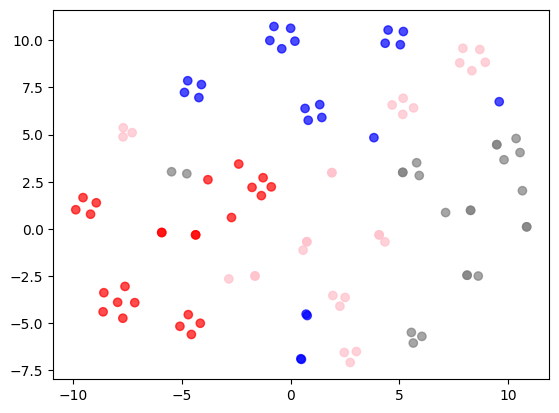

In [118]:
# plot the embeddings clusters using TSNE - remember complaints is a dataframe
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
tsne = TSNE(n_components=2, random_state=0)
# convert Pandas embedding array to a numpy array of arrays


matrix = np.array(complaints.embeddings.apply(literal_eval).to_list())

X_2d = tsne.fit_transform(matrix)
colors = ["red", "darkorange", "gold", "blue", "darkgreen","purple","pink","brown","black","grey"]
x = [x for x,y in X_2d]
y = [y for x,y in X_2d]
color_indices = complaints.Area.values 
print(color_indices)
colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.7)
plt.show()

In [87]:
# we want to build a preditive model to predict the category of a complaint
# we will use the embeddings as features and the category as the label
# split the data into training and test sets
from sklearn.model_selection import train_test_split
X = np.array(embeddings)
y = np.array(complaints['Score'])

numpy.ndarray

ValueError: could not convert string to float: '[-0.030742282047867775, -0.0037537249736487865, 0.021651538088917732, -0.027417365461587906, -0.027206258848309517, 0.0036778587382286787, -0.015212811529636383, -0.009644895792007446, -0.007566823158413172, -0.02760208211839199, 0.039714276790618896, 0.019237015396356583, -0.01642666943371296, -0.029290929436683655, -0.0039615323767066, 0.024567436426877975, 0.02121613174676895, -0.02469937689602375, 0.009301848709583282, -0.005574512295424938, -0.023815372958779335, 0.004990672692656517, -0.03134921193122864, 0.012864259071648121, -0.012613571248948574, -0.006775176618248224, 0.014513523317873478, -0.016400281339883804, 0.0009590469999238849, -0.0019659227691590786, -0.005043449345976114, -0.024989647790789604, -0.017732886597514153, 0.008074796758592129, -0.023657042533159256, -0.009941763244569302, 0.004390340764075518, -0.009638299234211445, 0.015291975811123848, -0.013345844112336636, 0.026441000401973724, -0.00020770418632309884, 0.009150116704404354, 0.002821890637278557, -0.01559544075280428, -0.006257307715713978, -0.004317773040384054, -0.01665096916258335, -0.029079822823405266, 0.026071565225720406, 0.013075364753603935, -0.005818603560328484, -0.006666325032711029, 0.0002072918723570183, -0.018748832866549492, 0.00496758334338665, 0.016413476318120956, -0.0072171795181930065, 0.004367250949144363, 0.00121880613733083, 0.002520075300708413, 0.012983006425201893, -0.006125366315245628, -0.010350780561566353, 0.002851577475667, -0.0029439362697303295, -0.0029356898739933968, 0.006554175168275833, -0.018669668585062027, -0.02034532092511654, 0.01527878176420927, 0.010937918908894062, 0.02239040844142437, 0.0023617460392415524, 0.004746581893414259, 0.0015635022427886724, 0.013187514618039131, 0.009295252151787281, 0.004492595326155424, 0.012191359885036945, 0.006755385547876358, -0.021453626453876495, -0.021348074078559875, -0.00843103788793087, 0.007672375999391079, -0.016505833715200424, -0.010396960191428661, 0.015107258222997189, -0.039978161454200745, -0.00405389117076993, 0.00985600147396326, 0.04100729897618294, 0.006560772191733122, -0.0034700515680015087, 0.0028647715225815773, 0.006900520529597998, 0.009710866957902908, 0.02894788235425949, -0.007230373565107584, -0.03884346783161163, -0.02111057937145233, 0.015621828846633434, -0.028604835271835327, -0.010799380950629711, -0.02184944972395897, -0.03881707787513733, 0.0096646873280406, -0.020424485206604004, 0.02067517302930355, -0.023287607356905937, -0.01647944562137127, 0.0046443273313343525, -0.011901088990271091, -0.02217930182814598, 0.01841898076236248, 0.009242475964128971, -0.0014323857612907887, -0.00739529961720109, 0.017363451421260834, -0.007362314499914646, 0.003747127717360854, 0.01559544075280428, 0.0241584200412035, 0.001674002967774868, -0.0075470320880413055, 0.009578925557434559, -0.0058153048157691956, -0.0017053389456123114, 0.005528333131223917, 0.0034667530562728643, 0.010535498149693012, 0.013642711564898491, 0.015186423435807228, -0.019302986562252045, -0.006310083903372288, 0.019131463021039963, -0.014328805729746819, 0.008919219486415386, -0.01593848690390587, -0.013629517517983913, 0.009090743027627468, 0.03902818262577057, -0.011597624979913235, 0.011848312802612782, 0.0004622062260750681, 0.0033249163534492254, 0.000665478000883013, -0.016400281339883804, 0.01372187677770853, -0.01213858276605606, 0.005023658275604248, -0.01889396831393242, 0.011426101438701153, 0.004848835989832878, -0.004093473311513662, -0.009565731510519981, 0.007909869775176048, -0.0139593705534935, -0.018287038430571556, -0.014289223589003086, 0.011511863209307194, -0.005749334115535021, 0.041851721704006195, -0.01735025830566883, 0.009783433750271797, 0.03580882027745247, -0.011683385819196701, -0.018775220960378647, -0.002844980452209711, -0.018075933679938316, -0.017957186326384544, 0.020015468820929527, -0.008543187752366066, 0.015569052658975124, 0.003984621725976467, 0.0010134727926924825, 0.030293680727481842, -0.011254577897489071, -0.006666325032711029, -0.011511863209307194, 0.01808912679553032, 0.005370003636926413, 0.0059868283569812775, 0.02739097736775875, 0.0031715347431600094, 0.0022941261995583773, 0.010957710444927216, -0.015806546434760094, 0.00904456339776516, 0.0002249183744424954, -0.020635591819882393, -0.007421688176691532, -0.014513523317873478, -0.04380445182323456, -0.6637166142463684, -0.013134738430380821, -0.0026305760256946087, 0.012422256171703339, 0.011010486632585526, -0.0005281767807900906, 0.015489887446165085, 0.016505833715200424, 0.011808730661869049, 0.007124820724129677, -0.0076921675354242325, 0.008437634445726871, -0.017469003796577454, -0.03319638594985008, -0.0011182009475305676, -0.007454673293977976, -0.0026371730491518974, 0.0009747150470502675, -0.018537728115916252, 0.007989034987986088, -0.043408628553152084, 0.029185375198721886, -0.004710298031568527, 0.017376646399497986, 0.035254668444395065, -0.008747695945203304, 0.022904979065060616, -0.0005776547477580607, -0.022205689921975136, 0.011155622079968452, -0.004040696658194065, 0.011663595214486122, -0.013359038159251213, 0.0033611999824643135, 0.041482288390398026, 0.0037702175322920084, -0.006623444147408009, -0.010093496181070805, 0.02148001454770565, 0.03791987895965576, -0.04317113384604454, -0.009644895792007446, -0.007065447047352791, -0.019237015396356583, 0.00934143178164959, 0.027259035035967827, 0.02394731342792511, -0.010080301202833652, -0.01680929958820343, 0.016716940328478813, 0.0018141904147341847, 0.002284230664372444, -0.006310083903372288, 0.02233763225376606, 0.004980777390301228, 0.0059010665863752365, 0.013642711564898491, -0.003951636608690023, -0.0019840647000819445, 0.004914806690067053, 0.001456300145946443, 0.006788370665162802, -0.0071841939352452755, -0.023907730355858803, -0.04208921641111374, -0.00953274592757225, -0.00697968527674675, -0.0006786721642129123, 0.046469662338495255, 0.005967037286609411, 0.03195613995194435, 0.02984508126974106, 0.02088627964258194, 0.015133646316826344, 0.02356468327343464, -0.007639390882104635, 0.03301166743040085, 0.00799563154578209, 0.0037801130674779415, 0.028314564377069473, -0.022364020347595215, -0.00971746351569891, 0.013761458918452263, 0.005046748090535402, 0.012765303254127502, -0.020490456372499466, -0.014183670282363892, -0.02984508126974106, -0.010509110055863857, -0.0015824688598513603, 0.003499738173559308, 0.007138014771044254, 0.016980823129415512, 0.004865328781306744, -0.00047869887202978134, 0.035254668444395065, -0.004710298031568527, -0.0027047928888350725, 0.036653243005275726, -0.024738959968090057, 0.011591027490794659, -0.0011338690528646111, -0.0012006642064079642, 0.007744943723082542, 0.005812006536871195, 0.0028664208948612213, 0.007520643994212151, -0.007500852923840284, 0.018392592668533325, -0.02669168822467327, 0.0062639047391712666, -0.00121880613733083, -0.014909346587955952, -0.020068245008587837, -0.004390340764075518, -0.029132599011063576, 0.006653130985796452, -0.002815293613821268, 0.004502490628510714, -0.011426101438701153, -0.014975316822528839, 0.013510771095752716, 0.016611387953162193, 0.0016764769097790122, 0.013682294636964798, 4.715864179161144e-06, 0.01578015834093094, -0.01254100352525711, -0.019157851114869118, 0.005670169834047556, 0.00165421178098768, 0.009473372250795364, 0.022786231711506844, -0.006395845673978329, 0.01841898076236248, -0.002719636308029294, 0.012837870977818966, -0.019883526489138603, 0.018827997148036957, -0.0450974740087986, -0.0070984321646392345, 0.0030082575976848602, 0.003156691323965788, -0.01927659846842289, 0.014025340788066387, -0.020041856914758682, 0.012633362784981728, 0.017257899045944214, -0.011162218637764454, 5.411647362052463e-05, -0.005996724124997854, -0.0037702175322920084, -0.00784389954060316, -0.002262790221720934, 0.025530606508255005, 0.003244102234020829, 0.006003321148455143, -0.01318091806024313, -0.004667417146265507, -0.02013421431183815, 0.017363451421260834, 0.006847744341939688, -0.005769125651568174, -0.007784526329487562, -0.022786231711506844, -0.015107258222997189, 0.005234763957560062, 0.01680929958820343, -0.03129643201828003, -0.026942376047372818, -0.004126458428800106, -0.013260082341730595, 0.0026025385595858097, 0.019263403490185738, 0.012349688448011875, 0.006313382647931576, -0.011650401167571545, -0.03475329279899597, -0.0007809264934621751, 0.009222684428095818, -0.005435974337160587, -0.006145157851278782, 0.018181486055254936, -0.00027439629775471985, 0.027681246399879456, -0.012560795061290264, -0.0030577355064451694, 0.014988510869443417, -0.006194635760039091, 0.004337564576417208, 0.01583293452858925, -0.0053963917307555676, 0.0013334299437701702, 0.0012254031607881188, -0.007520643994212151, -0.01081917155534029, -0.004423325881361961, 0.0032605950254946947, 0.0068213557824492455, 0.0020714756101369858, 0.037286560982465744, 0.026823630556464195, 0.022456379607319832, -0.013708682730793953, -0.009565731510519981, -0.022575125098228455, -0.000893901102244854, -0.022997336462140083, 0.014170476235449314, 0.023010531440377235, -0.0005846641142852604, -0.025464637205004692, 0.008285902440547943, -0.0332755520939827, 0.005544825457036495, -0.006211128085851669, 0.0007916467147879303, -0.008635546080768108, 0.005666871089488268, 0.014658658765256405, -0.010825769044458866, -0.0012336494401097298, 0.027232646942138672, -0.0050368523225188255, -0.01944812200963497, 0.009565731510519981, 0.004984075669199228, 0.005993425380438566, 0.0014760913327336311, 0.0062342179007828236, -0.003641574876382947, 0.015239199623465538, -0.004050592426210642, 0.023696625605225563, 0.0230896957218647, 0.01857730932533741, 0.026282671838998795, -0.007428285200148821, 0.013695488683879375, -0.007916467264294624, -0.0024178209714591503, -0.0005681714392267168, 0.028446504846215248, 0.0025712025817483664, -0.009836210869252682, -0.0007161928806453943, 0.022166108712553978, -0.003737232182174921, 0.002290827687829733, 0.009598716162145138, 0.02105780318379402, 0.013273276388645172, -0.010779589414596558, -0.004126458428800106, 0.0198703333735466, -0.026005594059824944, 0.01455310545861721, 0.00620123278349638, 0.027734024450182915, 0.03942400589585304, 0.0047597759403288364, 0.010865351185202599, 0.011426101438701153, -0.026335448026657104, 0.027338199317455292, 0.024514660239219666, -0.0009771889308467507, -0.018656473606824875, -0.024237584322690964, -0.025002842769026756, 0.034067198634147644, 0.011485474184155464, -0.001359818154014647, -0.026559747755527496, 0.022100137546658516, -0.02341954968869686, -0.010449736379086971, 0.0017663617618381977, 0.01245524175465107, -0.022839007899165154, -0.014526717364788055, -0.04000454768538475, 0.006973088253289461, 0.001037387060932815, -0.0071841939352452755, -0.014882958494126797, -0.004812552593648434, -0.0026866509579122066, 0.015173228457570076, -0.008919219486415386, 0.002045087283477187, 0.0019131462322548032, 6.715596828144044e-05, 0.010034122504293919, 0.0016327713383361697, -0.023432742804288864, 0.03285333886742592, 0.014328805729746819, -0.006808161735534668, -0.026493776589632034, 0.009506357833743095, -0.0016129801515489817, -0.010271616280078888, -0.02604517713189125, 0.026071565225720406, 0.025754906237125397, 0.009816419333219528, -0.03694351390004158, -0.009572328068315983, -0.014368387870490551, 0.016466252505779266, -0.01296321488916874, -0.012013238854706287, 0.028842328116297722, -0.005271047819405794, -0.00020883805700577796, 0.0005607497878372669, 0.011069860309362411, 0.03045201115310192, -0.014962122775614262, -0.004446415696293116, 0.008787279017269611, -0.00975044909864664, 0.005003867205232382, 0.08929774910211563, 0.02828817628324032, -0.0007998930523172021, 0.005907663609832525, 0.0006333173951134086, 0.0007631969056092203, -0.023591073229908943, -0.026071565225720406, 0.023538295179605484, 0.005851588677614927, 0.0077185556292533875, -0.013405217789113522, 0.029079822823405266, -0.005013762507587671, 0.002165483543649316, 0.007949452847242355, 0.0004395288706291467, -0.017376646399497986, 0.008358470164239407, -0.0316658690571785, -0.0019378851866349578, 0.014421164058148861, 0.04261698201298714, 0.045625239610672, -0.006273800507187843, -0.003453558776527643, 0.03662685677409172, 0.005224868189543486, 0.015569052658975124, 0.012006642296910286, 0.018880775198340416, 0.01492254063487053, -0.0010019278852269053, 0.013853817246854305, -0.010238630697131157, -0.0009244124521501362, -0.003301826538518071, -0.0265729408711195, 0.008576172403991222, 0.003994517493993044, 0.009427192620933056, 0.011511863209307194, 0.01950089819729328, 0.0017993469955399632, 0.01643986441195011, -0.011874700896441936, 0.01377465296536684, 0.013187514618039131, -0.007830705493688583, -4.9916005082195625e-05, 0.037339337170124054, -0.0033232669811695814, -0.029132599011063576, 0.0009837859543040395, 0.01605723425745964, 0.014289223589003086, 0.0017432720633223653, -0.02508200705051422, -0.0007875235751271248, 0.024936871603131294, -0.021875837817788124, -0.03908095881342888, -0.016360698267817497, -0.010416751727461815, -0.002196819754317403, -0.019144656136631966, -0.017469003796577454, -0.007804317399859428, 0.011386518366634846, -0.010535498149693012, -0.02270706743001938, -0.012679541483521461, -0.030953386798501015, -0.0014035237254574895, 0.0392129011452198, 0.005528333131223917, 0.007236970588564873, 0.016294728964567184, 0.007969243451952934, 0.032774172723293304, -0.0198703333735466, -0.009328236803412437, 0.014421164058148861, -0.010053913109004498, -0.012831274420022964, 0.011373324319720268, -0.011386518366634846, -0.003641574876382947, 0.0019147954881191254, 0.011511863209307194, -0.014104506000876427, 0.016624581068754196, -0.0037405306939035654, -0.025570189580321312, -0.011162218637764454, 0.004937896504998207, 0.027945129200816154, 0.008727905340492725, -0.018709251657128334, -0.004179235082119703, 0.022152913734316826, -0.0032556471414864063, -0.011689983308315277, 0.032351963222026825, 0.005181987304240465, 0.02422438934445381, 0.013134738430380821, -0.007500852923840284, -0.00990218110382557, -0.02196819707751274, 0.009189698845148087, -0.002313917502760887, -0.0063760546036064625, -0.0032210126519203186, 0.010113286785781384, 0.015080870129168034, 0.017482198774814606, 0.006913714576512575, 0.016980823129415512, -0.010707021690905094, -0.011934074573218822, -0.013418411836028099, 0.034067198634147644, 0.006626742891967297, -0.011993448249995708, 0.017574558034539223, 0.017059987410902977, -0.03179781138896942, 0.004538774490356445, 0.007817511446774006, -0.0018950043013319373, 0.021400850266218185, -0.020648784935474396, -0.013642711564898491, -0.016202369704842567, -0.01702040433883667, -0.025464637205004692, -0.01218476239591837, -0.021809866651892662, -0.007236970588564873, -0.015635022893548012, 0.0005694084102287889, 0.0038757703732699156, -0.008622352033853531, 0.011030278168618679, -0.01728428713977337, -0.02056962065398693, -0.00042757170740514994, 0.014407970011234283, 0.048343226313591, -0.00783730298280716, 0.0001669879857217893, -0.026190312579274178, 0.0003453146491665393, 0.0013152880128473043, -0.009519551880657673, -0.004822447896003723, -0.010772992856800556, 0.02282581478357315, 0.004403534810990095, 0.03311721980571747, -0.0010876896558329463, 0.012554197572171688, 0.0051226140931248665, -0.003112161299213767, 0.0029818692710250616, 0.008193543180823326, -0.02427716553211212, -0.002844980452209711, 0.025675741955637932, 0.027285423129796982, 0.009387610480189323, 0.027945129200816154, -0.027047930285334587, -0.010918127372860909, -0.003968129400163889, -0.006959894206374884, -0.002917547943070531, 0.009420596063137054, -0.01285766251385212, -0.02277303673326969, -0.01444755308330059, -0.002633874537423253, -0.016136398538947105, -0.004420027602463961, -0.0067388927564024925, 0.019672421738505363, -2.8192107492941432e-05, 0.029396481812000275, 0.009519551880657673, 0.031322821974754333, 0.004330967087298632, 0.01444755308330059, 0.030293680727481842, -0.004327668808400631, 0.007362314499914646, -0.019368955865502357, -0.024409107863903046, -0.01808912679553032, 0.010911530815064907, 0.026704883202910423, 0.02475215494632721, 0.012158374302089214, -0.008206738159060478, -0.0031814302783459425, 0.005551422480493784, -0.0009483267785981297, -0.04058508947491646, -0.013801041059195995, -0.00707204407081008, -0.005660274066030979, -0.020530037581920624, -0.010469527915120125, 0.002073124749585986, 0.011333742178976536, -0.004093473311513662, -0.009011578746140003, 0.008840055204927921, -0.01637389324605465, 0.0018026455072686076, -0.021295296028256416, 0.008371664211153984, -0.005076434463262558, -0.014711434952914715, 0.009051160886883736, -0.005976932588964701, -0.012257330119609833, -0.016189174726605415, -0.004990672692656517, 0.01277849730104208, -0.01207921002060175, 0.015569052658975124, 0.02422438934445381, -0.020978638902306557, -0.02067517302930355, 0.017759274691343307, 0.035307444632053375, -0.03243112936615944, -0.023749401792883873, 0.014210058376193047, 0.008609157986938953, -0.019777974113821983, 0.001178399077616632, 0.01948770321905613, -0.026124341413378716, 0.0013672398636117578, -0.010588275268673897, 0.00739529961720109, 0.004598148167133331, 0.01017266046255827, -0.00843103788793087, 0.017706498503684998, 0.005924156401306391, 0.024778543040156364, -0.021070996299386024, -0.010977501049637794, -0.008899428881704807, -0.007349120453000069, -0.009954957291483879, -0.007006073370575905, -0.02357787825167179, 0.027074318379163742, 0.0004650924529414624, 0.009493163786828518, -0.008813667111098766, 0.028815940022468567, -0.012791691347956657, -0.021598761901259422, 0.004779567010700703, 0.02111057937145233, -0.002444209298118949, -0.032140858471393585, 0.01294342428445816, 0.012573989108204842, 0.009348028339445591, -0.007619599811732769, -0.01922382041811943, -0.008470620028674603, -0.005716348998248577, 0.030056187883019447, 0.0026008894201368093, 0.007929661311209202, -0.00046550476690754294, -0.012771900743246078, -0.016822492703795433, -0.02571532502770424, -0.0023040217347443104, -0.016334310173988342, 0.011379921808838844, -0.00040386352338828146, -0.0022397006396204233, 0.008305693976581097, 0.003054436994716525, -0.0012542653130367398, -0.010746603831648827, 0.017600946128368378, 0.010007734410464764, 0.012409062124788761, -0.0001228701730724424, 0.01691485196352005, 0.0029554811771959066, 0.01814190484583378, -0.034014422446489334, -0.011986850760877132, 0.006475010421127081, -0.013867012225091457, 0.02889510616660118, -0.009743851609528065, -0.007744943723082542, 0.021889032796025276, -0.004047293681651354, -0.020661979913711548, -0.012633362784981728, -0.010185854509472847, 0.011630609631538391, 0.018062738701701164, 0.012864259071648121, -0.028815940022468567, -0.024989647790789604, 0.01981755718588829, -0.00026305762003175914, -0.010179257020354271, 0.013510771095752716, -0.017693303525447845, -0.017416227608919144, 0.011254577897489071, 0.02314247190952301, -0.010166062973439693, -0.03689073771238327, -0.02952842228114605, -0.022205689921975136, 0.014117700047791004, -0.02508200705051422, -0.03483245521783829, -0.025570189580321312, 0.005736140068620443, -0.0010505812242627144, -0.0021902224980294704, 0.0014200162841007113, 0.009202892892062664, 0.022535543888807297, 0.014698240906000137, 0.01409131195396185, 0.0033710957504808903, -0.008820263668894768, -0.0020846696570515633, -0.021757090464234352, -0.010772992856800556, -0.002206715289503336, -0.02228485606610775, -0.016994016245007515, 0.020411292091012, -0.00033356365747749805, -0.01626834087073803, -0.03298528119921684, 0.007025864906609058, -0.04649605229496956, 0.003140198765322566, -0.018181486055254936, 0.027074318379163742, 0.036917123943567276, 0.0001634832879062742, -0.0005685837822966278, 0.03174503520131111, -0.014381581917405128, 0.01819468103349209, 0.00880706962198019, -0.017917605116963387, 0.0075470320880413055, -0.0011685035424306989, 0.008285902440547943, 0.010027525015175343, -0.037128232419490814, 0.0031237059738487005, -0.0019048999529331923, 0.027100706472992897, 0.02931731753051281, -0.0029142494313418865, -0.0021143564954400063, 0.006580563262104988, 0.019857138395309448, 0.009288654662668705, 0.019355762749910355, 0.0025745010934770107, -0.00816055852919817, -0.027786800637841225, 0.0010769694345071912, 0.012494823895394802, -0.024765348061919212, -0.010377169586718082, -0.028657611459493637, 0.000356447184458375, 0.01712595671415329, 0.0023337085731327534, -0.027734024450182915, -0.003776814555749297, -0.0045618643052875996, -0.024659795686602592, -0.00985600147396326, -0.008694919757544994, 0.0008139117853716016, 0.0022413497790694237, 0.00010467672836966813, -0.008087990805506706, 0.02604517713189125, 0.008998384699225426, -0.01108965091407299, -0.012422256171703339, 0.0030165037605911493, -0.023617461323738098, 0.013081962242722511, -0.020965443924069405, 0.006554175168275833, -0.011630609631538391, -0.0002607898786664009, -0.00980322528630495, -0.012514615431427956, -0.00977023970335722, 0.03055756352841854, -0.0014109453186392784, -0.017429422587156296, 0.015766963362693787, 0.01052890159189701, 0.004007711540907621, -0.010159466415643692, -0.018075933679938316, -0.00020636415865737945, -0.013880206272006035, -0.04092813655734062, -0.010641051456332207, -0.0007108327699825168, -0.011109442450106144, -0.005079733207821846, 0.017693303525447845, -0.014368387870490551, 0.03153392672538757, 0.2438271939754486, -0.013068768195807934, 0.005472258199006319, 0.025161171332001686, -0.007514046970754862, -0.006125366315245628, 0.020820308476686478, -0.014843376353383064, -0.026757659390568733, 0.02265429124236107, -0.022693872451782227, 0.0034634543117135763, -0.006603653077036142, -0.008998384699225426, -0.03657407686114311, 0.0064354282803833485, -0.008952205069363117, -0.0046212379820644855, -0.009954957291483879, 0.026599330827593803, -0.004914806690067053, 0.02545144222676754, -0.005584408063441515, -0.006019813474267721, 0.011525057256221771, -0.003512932453304529, -0.006649832706898451, 0.01473782304674387, 0.035201892256736755, 0.027417365461587906, 0.004812552593648434, -0.018564116209745407, 0.0022809321526437998, 0.008642143569886684, -0.019395343959331512, -0.006834549829363823, 0.00262397900223732, -0.0037999043706804514, 0.019883526489138603, 0.007507449947297573, -0.014645464718341827, 0.0064057414419949055, 0.0050071654841303825, -0.02158556692302227, 0.013708682730793953, 0.028921494260430336, -0.013998952694237232, -0.0051523009315133095, -0.019474510103464127, 0.014751017093658447, -0.028710387647151947, 0.006761982571333647, 0.010812574997544289, 0.007830705493688583, -0.012798288837075233, -0.017812050879001617, 0.02368343062698841, 0.0011495370417833328, 0.017059987410902977, 0.00931504275649786, 0.002233103383332491, -0.024897290393710136, -0.00775813776999712, 0.0020945651922374964, -0.051245931535959244, 0.014460747130215168, -0.005132509395480156, 0.022311244159936905, 0.02093905583024025, -0.03190336376428604, 0.0021902224980294704, 0.0031138104386627674, 0.00262397900223732, 0.016070429235696793, -0.0241716131567955, -0.013629517517983913, 0.02351190708577633, 0.011973656713962555, -0.004551968537271023, -0.005894469562917948, 0.012752109207212925, 0.004634432028979063, -0.02513478323817253, -0.01691485196352005, -0.00799563154578209, -0.04639049991965294, -0.002523374045267701, 0.017271092161536217, -0.01766691543161869, 0.0016954434104263783, 0.02212652564048767, 0.008384858258068562, -0.01559544075280428, -0.011498668231070042, -0.003338110400363803, 0.005792215000838041, -0.009301848709583282, 0.032404739409685135, -0.0006407390465028584, 0.007289746776223183, -0.0029719737358391285, 0.0055712140165269375, -0.007626196835190058, -0.0012328248703852296, -0.002455754205584526, -0.0021259014029055834, -0.01011988427489996, 0.05304032936692238, -0.0007149559678509831, -0.01588571071624756, 0.009954957291483879, -0.021189743652939796, 0.015766963362693787, -0.012884050607681274, -0.00017430659499950707, 0.026599330827593803, -0.007784526329487562, 0.011597624979913235, 0.010693827643990517, 0.011663595214486122, 0.009097340516746044, -0.03082144632935524, -0.008906025439500809, 0.02105780318379402, 0.00725016463547945, 0.01207921002060175, -0.023274414241313934, -0.0026008894201368093, -0.007019267417490482, 0.012395868077874184, 0.011122636497020721, 0.001985713839530945, 0.02760208211839199, -0.015305169858038425, -0.024818124249577522, 0.01815509796142578, -0.0007240268751047552, 0.020899472758173943, -0.009559134021401405, -0.02394731342792511, 0.017653722316026688, 0.011109442450106144, 0.0038097999058663845, -0.019184239208698273, 0.0034205736592411995, -0.010621259920299053, 0.04425305128097534, 0.014104506000876427, -0.04076980799436569, -0.008055005222558975, -0.024039672687649727, -0.019289791584014893, 0.00046880330774001777, -0.03966150060296059, 0.015080870129168034, -0.009776837192475796, -0.05515138804912567, -0.03462135046720505, 0.004548670258373022, 0.01621556468307972, -0.026770852506160736, -0.01533155795186758, 0.01702040433883667, -0.01750858686864376, 0.005254555027931929, 0.002709740772843361, -0.1680402159690857, 0.007929661311209202, -0.018933551385998726, 0.0030296980403363705, 0.015912098810076714, -0.008371664211153984, 0.01793079823255539, -0.018537728115916252, -0.03834208846092224, 0.002863122383132577, 0.014645464718341827, -0.0018851087661460042, -0.014434359036386013, 0.02685001865029335, -0.003394185332581401, 0.0005335368914529681, -0.020846696570515633, 0.005828498862683773, 0.02347232587635517, 0.01044313982129097, 0.01616278663277626, -0.009295252151787281, 0.024936871603131294, -0.02062239684164524, 0.020477261394262314, 0.0035030366852879524, -0.026163924485445023, 0.029977021738886833, -0.010185854509472847, -0.02421119622886181, -0.02340635471045971, 0.028683999553322792, 0.007533838041126728, -0.0005265275249257684, 0.02604517713189125, 0.009836210869252682, 0.0028680700343102217, 0.010799380950629711, 0.03762960806488991, 0.029765916988253593, 0.01136013027280569, 0.012633362784981728, -0.016519028693437576, 0.02356468327343464, -0.0013012692797929049, 0.032563067972660065, 0.0037537249736487865, -0.011379921808838844, -0.019302986562252045, 0.00016379253065679222, 0.011017083190381527, -0.04317113384604454, -0.004020905587822199, -0.0054821535013616085, 0.0067685795947909355, 0.018590504303574562, 0.005168793257325888, -0.009697671979665756, -0.0050665391609072685, -0.028842328116297722, -0.01382742915302515, -0.0004584954003803432, 0.02620350569486618, 0.0024112239480018616, -0.0028284878935664892, -0.015489887446165085, 0.0022495961748063564, -0.028525670990347862, -0.007520643994212151, 0.010383766144514084, -0.00971746351569891, -0.024184808135032654, -0.0005471433396451175, -0.007553629111498594, -0.0008815316250547767, 0.002843331079930067, 0.01745581068098545, 0.02604517713189125, 0.006352964788675308, -0.003822993952780962, -0.014276029542088509, 0.04945153370499611, 0.0005017885705456138, -0.025200754404067993, -0.0015437110560014844, 0.02136126719415188, 0.005630587227642536, 0.009862598963081837, 0.03631019592285156, 0.00697968527674675, 0.013457993976771832, -0.03356582298874855, -0.003948337864130735, 0.013998952694237232, 0.0010357378050684929, 0.026375029236078262, 0.003839486511424184, -0.007962646894156933, -0.00707204407081008, 0.01321390364319086, -0.0023534996435046196, 0.020068245008587837, 0.006834549829363823, 0.026889599859714508, 0.027734024450182915, 0.0035030366852879524, -0.0075734201818704605, 0.019909914582967758, 0.0041990261524915695, -0.016769716516137123, 0.0030395935755223036, -0.007039058953523636, -0.0010332638630643487, -0.007428285200148821, 0.014434359036386013, 0.027259035035967827, 0.004908209666609764, -0.012112194672226906, 0.014724628999829292, -0.025847265496850014, 0.08090629428625107, -0.004159444011747837, -0.044754426926374435, -0.002460701856762171, 0.008259514346718788, 0.005323824007064104, -0.12328578531742096, -0.01804954558610916, 0.0012963215121999383, 0.028499282896518707, 0.0028944583609700203, 0.016835687682032585, -0.006900520529597998, 0.02034532092511654, 0.006125366315245628, 0.012831274420022964, -0.009282058104872704, -0.009189698845148087, -0.023749401792883873, -0.01589890569448471, 0.038315702229738235, -0.014249641448259354, 0.02963397651910782, 0.006306785624474287, -0.015423917211592197, 0.012191359885036945, -0.03580882027745247, -0.008477216586470604, -0.013919788412749767, -0.006445323582738638, 0.009888987056910992, 0.010007734410464764, -0.016307922080159187, 0.023868149146437645, 0.017600946128368378, 0.03280056267976761, 0.009031369350850582, 0.00017337888129986823, 0.01546349935233593, 0.00298681715503335, 0.011749356985092163, -0.014025340788066387, -0.03752405568957329, -0.018023157492280006, 0.010298004373908043, -0.019949497655034065, -0.0005376600893214345, -0.004152846988290548, -0.006082485895603895, -0.03190336376428604, 0.001160257263109088, 0.006039605010300875, 0.009631701745092869, 0.004835641942918301, 0.013735070824623108, -0.008985190652310848, -0.018432173877954483, 0.010990695096552372, -0.02604517713189125, 0.016571804881095886, 0.019725197926163673, -0.002930742222815752, 0.026441000401973724, -0.007817511446774006, -0.023340383544564247, -0.009526149369776249, 0.018616892397403717, -0.004964284598827362, -0.009176504798233509, 0.018933551385998726, -0.0009912076639011502, -0.015912098810076714, -0.01971200294792652, -0.009651493281126022, -0.004423325881361961, -0.0020285947248339653, -0.01965922676026821, 0.01889396831393242, -0.02034532092511654, 0.0005009639426134527, -0.02989785745739937, 0.0055118403397500515, -0.022904979065060616, -0.02314247190952301, 0.0038856659084558487, -0.022997336462140083, -0.018827997148036957, -0.010918127372860909, 0.0007434057770296931, -0.004502490628510714, 0.0075734201818704605, -0.00262397900223732, 0.01568779908120632, 0.012633362784981728, 0.013919788412749767, 0.011313951574265957, -0.019580062478780746, -0.012567391619086266, -0.006326576694846153, -0.007527241017669439, 0.006085784174501896, 0.02270706743001938, -0.008417843841016293, -0.010278213769197464, 0.0014431059826165438, -0.011597624979913235, -0.001387855620123446, -0.0011379921343177557, -0.01296321488916874, 0.014539911411702633, -0.010146272368729115, -0.014909346587955952, -0.008965399116277695, -0.005211674142628908, 0.0032836846075952053, -0.007507449947297573, -0.005300734657794237, -0.022693872451782227, -0.025754906237125397, 0.022535543888807297, -0.03314360976219177, 0.0010522304801270366, -0.025332694873213768, -0.02422438934445381, 0.024079253897070885, -0.010772992856800556, 0.020411292091012, 0.022627903148531914, -0.012296912260353565, -0.013464591465890408, 0.01062785740941763, -0.004093473311513662, -0.005689960904419422, 0.01729748025536537, -0.0005285891238600016, 0.013603129424154758, -0.01819468103349209, -0.014025340788066387, -0.00524795800447464, -0.034119974821805954, 0.002274335129186511, 0.000931834161747247, -0.03055756352841854, -0.02266748435795307, 0.007111626211553812, 0.0041396524757146835, 0.020200185477733612, -0.026652107015252113, -0.026124341413378716, -0.026718076318502426, -0.0010283160954713821, -0.004439818672835827, -0.005076434463262558, 0.005023658275604248, 0.008628949522972107, 0.008549784310162067, 0.008312290534377098, -0.0076921675354242325, 0.018511340022087097, 0.021453626453876495, 0.008734501898288727, -0.011096248403191566, -0.01803635060787201, 0.012699333019554615, 0.026546552777290344, -0.01632111705839634, 0.017574558034539223, -0.008358470164239407, 0.00784389954060316, -0.010238630697131157, 6.019813736202195e-05, -0.016175981611013412, -0.0009442036389373243, -0.008404649794101715, 0.00230237259529531, 0.010911530815064907, 0.02636183612048626, -0.038262926042079926, -0.014051729813218117, 0.003654769156128168, 0.007085238117724657, 0.004825746640563011, 0.011142428033053875, -0.001531341578811407, -0.007520643994212151, -0.02625628374516964, 0.0035030366852879524, -0.0016797754215076566, 0.00971746351569891, -0.01750858686864376, -0.004271593876183033, 0.009136922657489777, 0.01277849730104208, 0.04311835765838623, 0.000931834161747247, 0.003052787622436881, -0.005887872539460659, 0.020609203726053238, -0.009018175303936005, 0.003034645691514015, -0.005280943587422371, -0.004852134734392166, 0.011881298385560513, 0.030346456915140152, 0.008787279017269611, 0.027997905388474464, 0.009836210869252682, 0.028631223365664482, 0.017693303525447845, 0.008417843841016293, -0.005980231333523989, -0.003061034018173814, -0.016241952776908875, 0.007461270317435265, -0.03153392672538757, -0.026295864954590797, -0.018075933679938316, 0.013134738430380821, 0.025042423978447914, -0.022192496806383133, -0.02272026054561138, 0.02207374945282936, -0.004631133284419775, -0.015872517600655556, -0.005280943587422371, -0.008239722810685635, -0.008391455747187138, 0.0563652478158474, 0.005459063686430454, 0.023379966616630554, 0.0003100616449955851, -0.01409131195396185, 0.027179870754480362, 0.0002737778122536838, -0.013761458918452263, 0.0020780726335942745, -0.0020104527939110994, -0.008628949522972107, -0.00391865149140358, 0.0037240381352603436, -0.02905343472957611, -0.026704883202910423, 0.018353009596467018, -0.013095156289637089, -0.017719691619277, 0.021282102912664413, -0.002777360612526536, 0.030003411695361137, 0.005528333131223917, -0.020965443924069405, 0.00688732648268342, 0.0029901156667619944, -0.0011775745078921318, 0.017864827066659927, 0.005976932588964701, 0.0041693393141031265, -0.026375029236078262, 0.0048323436640203, -0.007520643994212151, 0.005544825457036495, -0.033856090158224106, -0.05121954157948494, -0.009888987056910992, 0.029818693175911903, 0.014645464718341827, -0.03467412665486336, -0.018973132595419884, 0.013187514618039131, 0.009103937074542046, 0.011788939125835896, 0.00843103788793087, -0.007032461930066347, -0.002025296213105321, 0.01149207167327404, -0.01066084299236536, 0.0009425543830730021, -0.0241584200412035, 0.008595963940024376, -0.001977467443794012, -0.03124365769326687, -0.00907754898071289, 0.004667417146265507, -0.01208580657839775, -0.027681246399879456, -0.006478309165686369, -0.00043705495772883296, 0.005370003636926413, -0.030346456915140152, 0.0612206794321537, -0.012296912260353565, -0.00766577897593379, 0.014236447401344776, -0.002464000368490815, -0.024092448875308037, -0.006151754874736071, -0.02078072726726532]'